In [1]:
import re
import collections
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm, trange

from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import silhouette_score

from MulticoreTSNE import MulticoreTSNE as TSNE
from umap import UMAP

/home/asemenov/study/otus/MLProfessional/.venv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words('english')) | {'rt'}

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/asemenov/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
elon_df = pd.concat([
    pd.read_csv('data/elon/2019.csv', index_col=0).set_index('id', drop=True),
    pd.read_csv('data/elon/2020.csv', index_col=0).set_index('id', drop=True),
    pd.read_csv('data/elon/2021.csv', index_col='id'),
])[['tweet', 'date']]
elon_df.rename(columns={'tweet': 'text'}, inplace=True)
elon_df['datetime'] = pd.to_datetime(elon_df['date'])
elon_df['date'] = pd.to_datetime(elon_df['datetime'].dt.date)
elon_df = elon_df.query("date >= '2019-01-01' and date < '2022-01-01'")
elon_df.drop_duplicates(inplace=True)
elon_df.head()

,text,date,datetime
id,,,
1211071324518531072,@Joe__Wakefield @austinbarnard45 @tjq1190 @tyg...,2019-12-28,2019-12-28 23:47:59
1211069054779301894,@austinbarnard45 @tjq1190 @tyger_cyber @fawful...,2019-12-28,2019-12-28 23:38:57
1211064937004589056,@IrinaAntony @tjq1190 @tyger_cyber @fawfulfan ...,2019-12-28,2019-12-28 23:22:36
1211054942192119808,@tjq1190 @tyger_cyber @fawfulfan @_Mikemo He d...,2019-12-28,2019-12-28 22:42:53
1211051740562366464,@geofficient Pretty much,2019-12-28,2019-12-28 22:30:09


In [4]:
elon_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9377 entries, 1211071324518531072 to 1344810193952014336
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   text      9377 non-null   object        
 1   date      9377 non-null   datetime64[ns]
 2   datetime  9377 non-null   datetime64[ns]
dtypes: datetime64[ns](2), object(1)
memory usage: 293.0+ KB


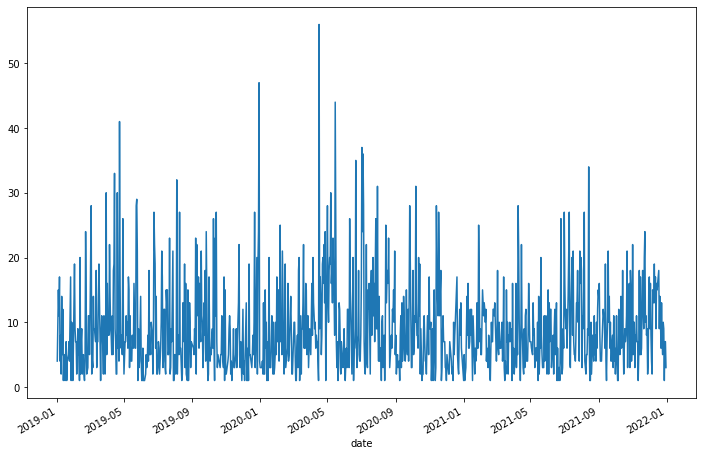

In [5]:
elon_df.groupby('date')['text'].count().plot(figsize=(12, 8));

In [6]:
elon_df['text'].head()

id
1211071324518531072    @Joe__Wakefield @austinbarnard45 @tjq1190 @tyg...
1211069054779301894    @austinbarnard45 @tjq1190 @tyger_cyber @fawful...
1211064937004589056    @IrinaAntony @tjq1190 @tyger_cyber @fawfulfan ...
1211054942192119808    @tjq1190 @tyger_cyber @fawfulfan @_Mikemo He d...
1211051740562366464                             @geofficient Pretty much
Name: text, dtype: object

In [7]:
def text_preprocessor(v: str) -> str:
    v = v.lower()
    v = re.sub(r'@[^\s]+', '', v)
    v = re.sub(r'https?://[^\s]+', '', v)
    v = re.sub(r'&\w+;', '', v)
    v = re.sub('\W+', ' ', v)
    v = v.strip()
    return v

In [8]:
empty_tweets = (
    elon_df.text
    .apply(text_preprocessor)
    .apply(lambda v: ' '.join(word for word in v.split() if word not in stop_words))
    .apply(lambda v: not not re.fullmatch('\W*', v))
)
print(elon_df[empty_tweets].shape)
elon_df[empty_tweets]

(732, 3)


,text,date,datetime
id,,,
1210263196457504768,@teslaownersSV @tesla_unplugged @TeslaOwnersof...,2019-12-26,2019-12-26 18:16:46
1209141597629243393,@markets 🤣🤣,2019-12-23,2019-12-23 15:59:56
1205682780178280448,https://t.co/LxZAmZIcIS,2019-12-14,2019-12-14 02:55:49
1205680930779590657,https://t.co/aAEFph9G6D,2019-12-14,2019-12-14 02:48:29
1205050955927932928,@SamTalksTesla https://t.co/z6zljrfUmb,2019-12-12,2019-12-12 09:05:11
...,...,...,...
1348017194349694978,@BoredElonMusk 🤣🤣,2021-01-10,2021-01-10 00:00:00
1348007662491820033,@erigganewmoney 😢,2021-01-10,2021-01-10 00:00:00
1347976356135518211,@Christo49699922 @sean18743005 @Erdayastronaut...,2021-01-09,2021-01-09 00:00:00


In [9]:
elon_df = elon_df[~empty_tweets]
elon_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8645 entries, 1211071324518531072 to 1344810193952014336
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   text      8645 non-null   object        
 1   date      8645 non-null   datetime64[ns]
 2   datetime  8645 non-null   datetime64[ns]
dtypes: datetime64[ns](2), object(1)
memory usage: 270.2+ KB


In [10]:
tweet_words = collections.Counter()
elon_df.text.apply(text_preprocessor).str.split().apply(lambda arr: [v for v in arr if v not in set(stop_words)]).apply(tweet_words.update)
len(tweet_words), tweet_words.most_common(50)

(9651,
 [('tesla', 661),
  ('yes', 386),
  ('great', 327),
  ('good', 295),
  ('much', 288),
  ('would', 283),
  ('like', 252),
  ('high', 240),
  ('starship', 225),
  ('haha', 222),
  ('true', 216),
  ('time', 214),
  ('one', 208),
  ('probably', 197),
  ('sure', 188),
  ('also', 186),
  ('yeah', 186),
  ('make', 185),
  ('production', 183),
  ('year', 183),
  ('work', 176),
  ('next', 172),
  ('many', 170),
  ('spacex', 167),
  ('3', 164),
  ('car', 164),
  ('soon', 164),
  ('exactly', 162),
  ('new', 159),
  ('people', 158),
  ('2', 157),
  ('need', 153),
  ('get', 152),
  ('hard', 150),
  ('mars', 150),
  ('even', 148),
  ('cars', 145),
  ('coming', 142),
  ('engine', 141),
  ('lot', 140),
  ('1', 140),
  ('years', 140),
  ('team', 139),
  ('first', 136),
  ('long', 132),
  ('better', 132),
  ('10', 131),
  ('way', 131),
  ('still', 131),
  ('maybe', 129)])

In [11]:
tfidf_vectorizer = TfidfVectorizer(
    stop_words=stop_words,
    ngram_range=(1, 2),
    max_features=3000,
    preprocessor=text_preprocessor
)
tfidf_vectorizer.fit(elon_df.text)
len(tfidf_vectorizer.vocabulary_)

3000

In [12]:
text_tfidf = tfidf_vectorizer.transform(elon_df.text).toarray()

In [13]:
%%time
pca = PCA(n_components=2, random_state=42)
text_pca = pca.fit_transform(text_tfidf)
print('PCA done!')

umap = UMAP(n_components=2, n_jobs=-1, random_state=42)
text_umap = umap.fit_transform(text_tfidf)
print('UMAP done!')

umap_cosine = UMAP(n_components=2, n_jobs=-1, metric='cosine', random_state=42)
text_umap_cosine = umap_cosine.fit_transform(text_tfidf)
print('UMAP(cosine) done!')

PCA done!
UMAP done!
UMAP(cosine) done!
CPU times: user 1min 54s, sys: 8.43 s, total: 2min 2s
Wall time: 1min 22s


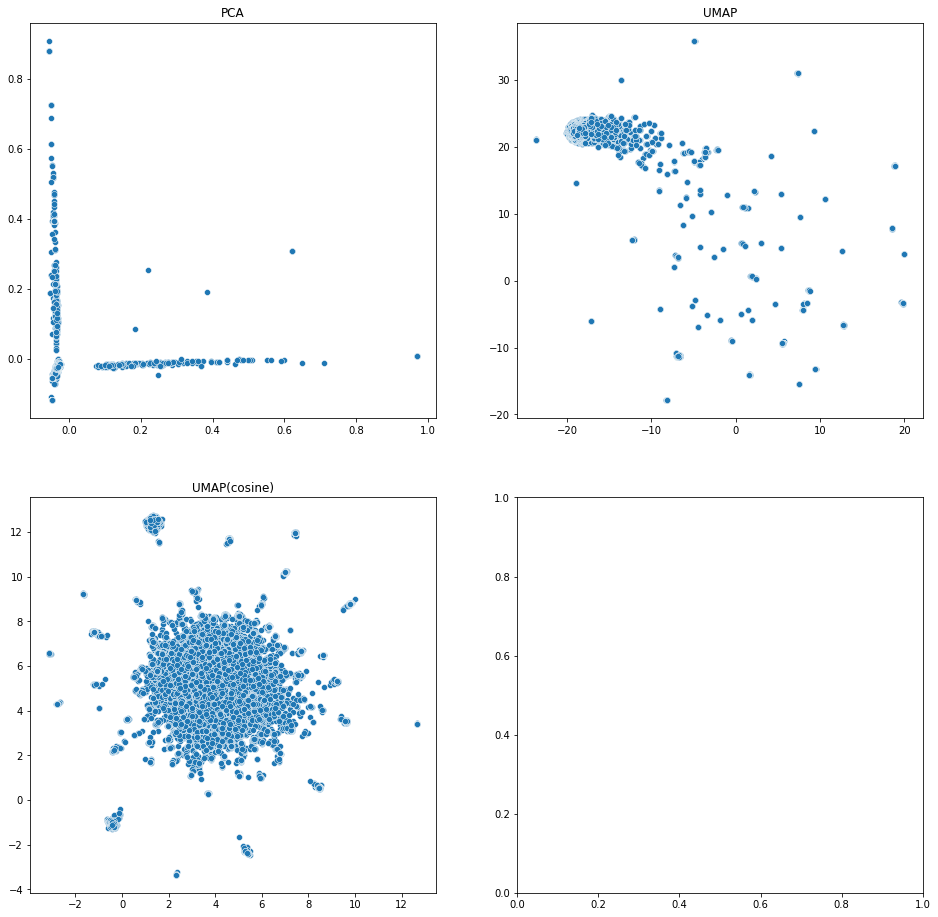

In [14]:
fig, ((ax11, ax12), (ax21, ax22)) = plt.subplots(2, 2, figsize=(16, 16))

ax11.set_title('PCA')
sns.scatterplot(x=text_pca[..., 0], y=text_pca[..., 1], ax=ax11);

ax12.set_title('UMAP')
sns.scatterplot(x=text_umap[..., 0], y=text_umap[..., 1], ax=ax12);

ax21.set_title('UMAP(cosine)')
sns.scatterplot(x=text_umap_cosine[..., 0], y=text_umap_cosine[..., 1], ax=ax21);

In [15]:
K = list(range(1, 31))

inertia = {}
silhouette = {}

for k in tqdm(K):
    kmeans = KMeans(n_clusters=k, random_state=42).fit(text_tfidf)
    inertia[k] = kmeans.inertia_
    silhouette[k] = silhouette_score(text_tfidf, kmeans.labels_) if k > 1 else None

100%|████████████████████████████████████████████████████████████████████| 30/30 [06:49<00:00, 13.65s/it]


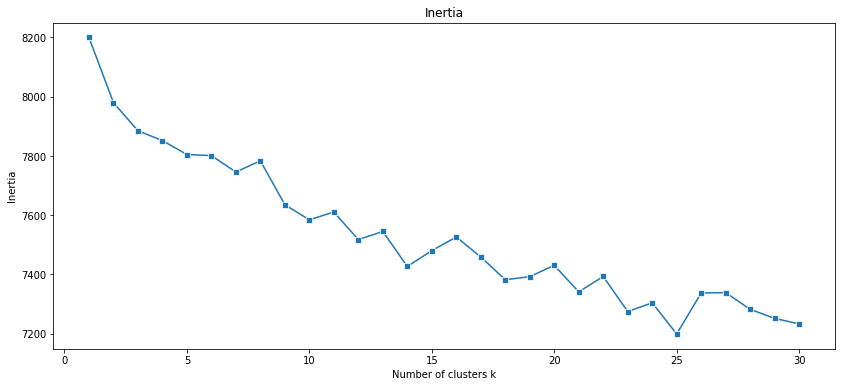

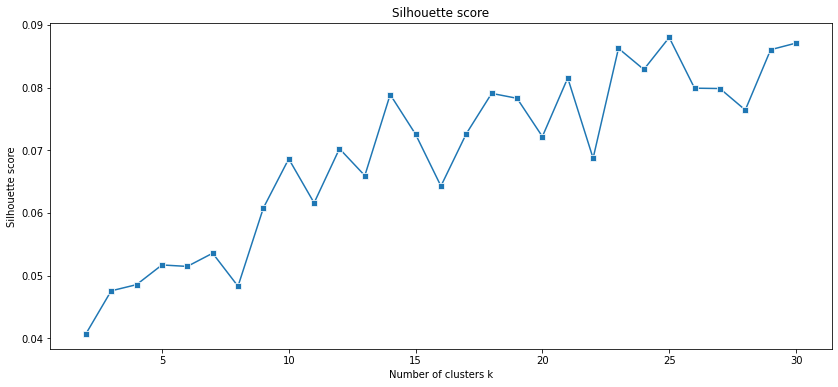

In [16]:
plt.figure(figsize=(14, 6))
sns.lineplot(x=K, y=[inertia[k] for k in K], marker='s')

plt.title('Inertia')
plt.xlabel('Number of clusters k')
plt.ylabel('Inertia')

plt.show()

plt.figure(figsize=(14, 6))
sns.lineplot(x=K, y=[silhouette[k] for k in K], marker='s')

plt.title('Silhouette score')
plt.xlabel('Number of clusters k')
plt.ylabel('Silhouette score')

plt.show()

In [17]:
d = {}
for k in K[1:-1]:
    d[k] = (inertia[k] - inertia[k + 1]) / (inertia[k - 1] - inertia[k])

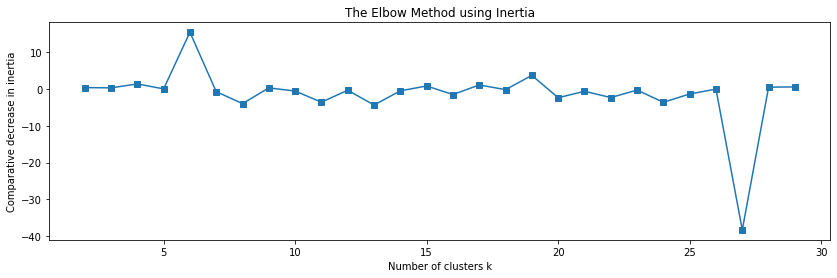

In [18]:
plt.figure(figsize=(14, 4))
plt.plot(list(d.keys()), list(d.values()), marker='s')

plt.title('The Elbow Method using Inertia')
plt.xlabel('Number of clusters k')
plt.ylabel('Comparative decrease in inertia')

plt.show()

In [19]:
kmeans = KMeans(
    n_clusters=2,
    # eps=0.6,
    # metric='cosine',
    random_state=42
)
clusters = kmeans.fit_predict(text_tfidf)
# clusters = kmeans.fit_predict(text_pca)
print(len(set(clusters)))

2


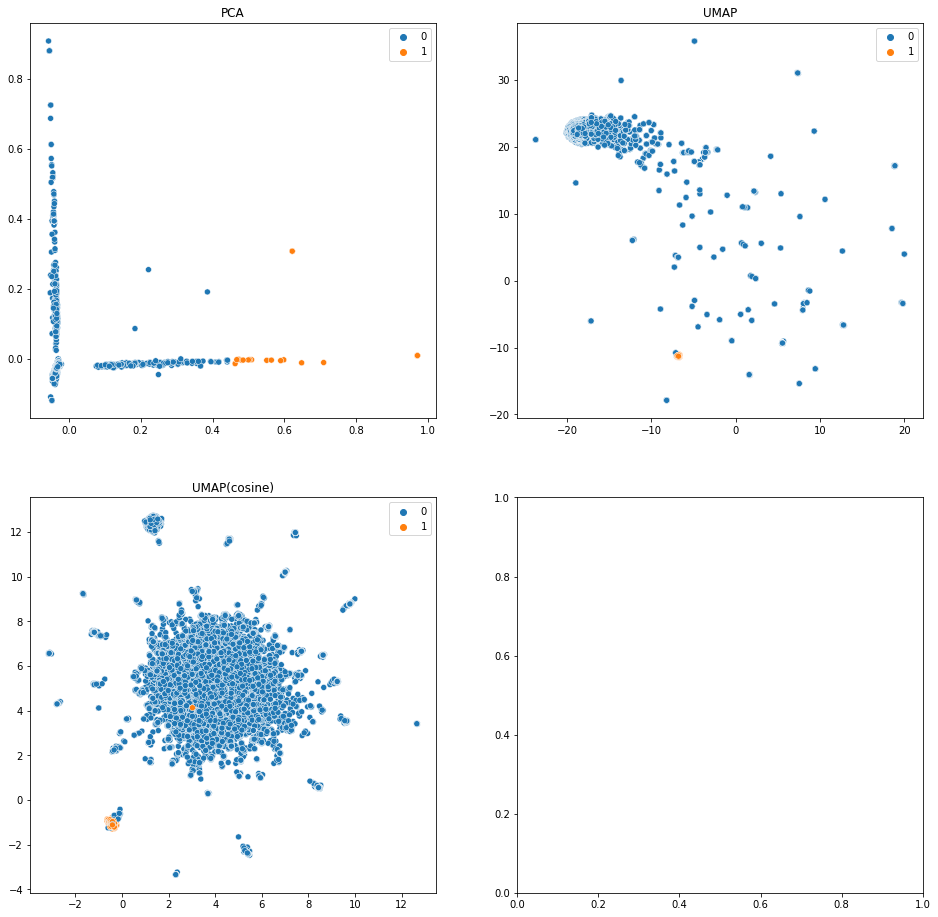

In [20]:
fig, ((ax11, ax12), (ax21, ax22)) = plt.subplots(2, 2, figsize=(16, 16))

ax11.set_title('PCA')
sns.scatterplot(x=text_pca[..., 0], y=text_pca[..., 1], ax=ax11, hue=clusters);

ax12.set_title('UMAP')
sns.scatterplot(x=text_umap[..., 0], y=text_umap[..., 1], ax=ax12, hue=clusters);

ax21.set_title('UMAP(cosine)')
sns.scatterplot(x=text_umap_cosine[..., 0], y=text_umap_cosine[..., 1], ax=ax21, hue=clusters);

In [21]:
elon_df['cluster'] = clusters

In [22]:
elon_df.groupby('cluster')['cluster'].count()

cluster
0    8404
1     241
Name: cluster, dtype: int64

In [23]:
def print_top_n_words(data: pd.Series, n: int = 25):
    words_counter = collections.Counter()
    data.apply(text_preprocessor).str.split().apply(lambda arr: [v for v in arr if v in tfidf_vectorizer.vocabulary_]).apply(words_counter.update)
    return words_counter.most_common(n)

In [24]:
elon_df.query('cluster == 0').head(10)

,text,date,datetime,cluster
id,,,,
1211071324518531072,@Joe__Wakefield @austinbarnard45 @tjq1190 @tyg...,2019-12-28,2019-12-28 23:47:59,0
1211069054779301894,@austinbarnard45 @tjq1190 @tyger_cyber @fawful...,2019-12-28,2019-12-28 23:38:57,0
1211064937004589056,@IrinaAntony @tjq1190 @tyger_cyber @fawfulfan ...,2019-12-28,2019-12-28 23:22:36,0
1211054942192119808,@tjq1190 @tyger_cyber @fawfulfan @_Mikemo He d...,2019-12-28,2019-12-28 22:42:53,0
1211051740562366464,@geofficient Pretty much,2019-12-28,2019-12-28 22:30:09,0
1211030324660051968,@annerajb @justpaulinelol Federal,2019-12-28,2019-12-28 21:05:03,0
1211030194787700736,@justpaulinelol @annerajb Probably 2021. Depen...,2019-12-28,2019-12-28 21:04:32,0
1211029491188948992,@annerajb Hopefully working in Caribbean by en...,2019-12-28,2019-12-28 21:01:45,0
1211010494695391232,@waitbutwhy @Kurz_Gesagt Maximizing conversion...,2019-12-28,2019-12-28 19:46:16,0


In [25]:
print_top_n_words(elon_df.query('cluster == 0').text)

[('tesla', 660),
 ('great', 327),
 ('good', 294),
 ('much', 288),
 ('would', 283),
 ('like', 252),
 ('high', 240),
 ('starship', 225),
 ('haha', 219),
 ('true', 216),
 ('time', 214),
 ('one', 208),
 ('probably', 197),
 ('sure', 188),
 ('also', 186),
 ('yeah', 186),
 ('make', 185),
 ('production', 183),
 ('year', 183),
 ('work', 176),
 ('next', 172),
 ('many', 170),
 ('spacex', 167),
 ('car', 164),
 ('soon', 164)]

In [26]:
elon_df.query('cluster == 1').head(10)

,text,date,datetime,cluster
id,,,,
1210777492027363328,"@TheAssassin_95 Yes, but it’s too secret",2019-12-28,2019-12-28 04:20:23,1
1209536537794359297,@Erdayastronaut @Tesla Yes,2019-12-24,2019-12-24 18:09:17,1
1208841343440568320,@youfoundalec @EV_Stevee @teslaownersSV @cgpgr...,2019-12-22,2019-12-22 20:06:50,1
1208832682693541888,@RenataKonkoly Yes 🤣♥️,2019-12-22,2019-12-22 19:32:25,1
1208468535292203008,@teslaownersSV Yes,2019-12-21,2019-12-21 19:25:25,1
1205806734960234496,@Kristennetten Yes,2019-12-14,2019-12-14 11:08:23,1
1201950417145327616,@Ragnvaldr1 Yes,2019-12-03,2019-12-03 19:44:45,1
1198347877237420032,@somepitch Yes,2019-11-23,2019-11-23 21:09:32,1
1197895848950026240,@mithunoorath @Tesla Yes,2019-11-22,2019-11-22 15:13:20,1


In [27]:
print_top_n_words(elon_df.query('cluster == 1').text)

[('yes', 241),
 ('haha', 3),
 ('irony', 1),
 ('months', 1),
 ('full', 1),
 ('slightly', 1),
 ('play', 1),
 ('good', 1),
 ('called', 1),
 ('tesla', 1),
 ('improvement', 1),
 ('insane', 1),
 ('even', 1),
 ('lot', 1),
 ('mars', 1),
 ('unfortunately', 1),
 ('long', 1)]

In [28]:
elon_df.query('cluster == 2').head(10)

,text,date,datetime,cluster
id,,,,


In [29]:
print_top_n_words(elon_df.query('cluster == 2').text)

[]

In [30]:
EPS = np.linspace(0.01, 1.5, 101)

silhouette = {}
clusters = {}

for eps in tqdm(EPS):
    dbscan = DBSCAN(eps=eps, n_jobs=-1).fit(text_tfidf) # metric='cosine' checked
    clusters[eps] = len(set(dbscan.labels_)) - 1
    # print(set(dbscan.labels_))
    if len(set(dbscan.labels_)) > 1:
        # print(eps, set(dbscan.labels_))
        silhouette[eps] = silhouette_score(text_tfidf, dbscan.labels_)
# print(silhouette

100%|██████████████████████████████████████████████████████████████████| 101/101 [10:41<00:00,  6.35s/it]


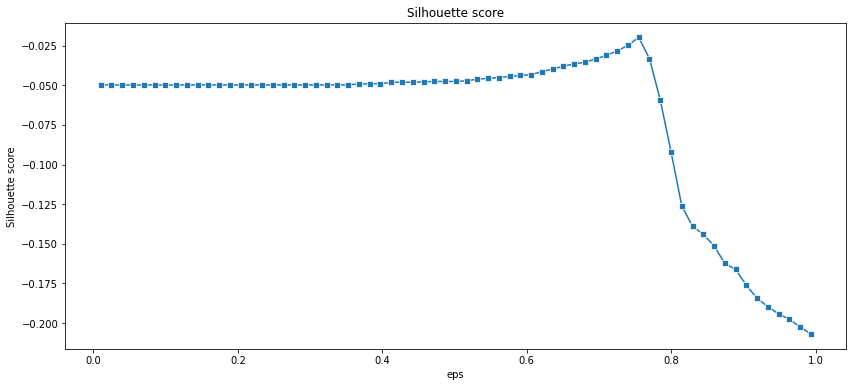

In [31]:
plt.figure(figsize=(14, 6))
sns.lineplot(x=EPS, y=[silhouette.get(eps) for eps in EPS], marker='s')

plt.title('Silhouette score')
plt.xlabel('eps')
plt.ylabel('Silhouette score')

plt.show()

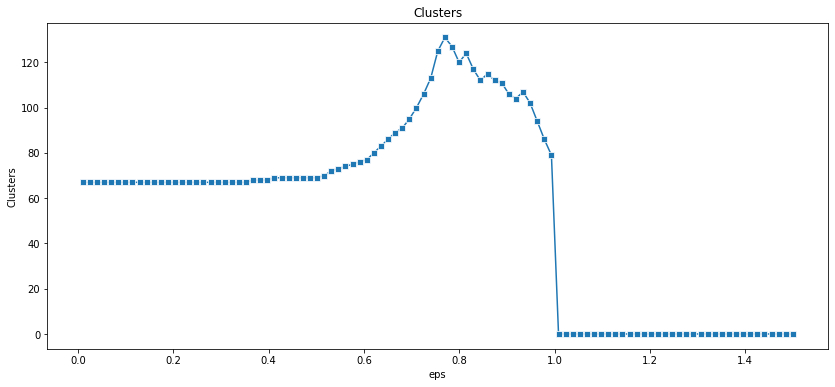

In [32]:
plt.figure(figsize=(14, 6))
sns.lineplot(x=EPS, y=[clusters.get(eps) for eps in EPS], marker='s')

plt.title('Clusters')
plt.xlabel('eps')
plt.ylabel('Clusters')

plt.show()

In [33]:
best_eps = [*silhouette.keys()][np.argmax([*silhouette.values()])]
best_eps

0.755

In [34]:
dbscan = DBSCAN(eps=best_eps, n_jobs=-1) # metric='cosine' checked
elon_df['clusters_dbsacn'] = dbscan.fit_predict(text_tfidf)

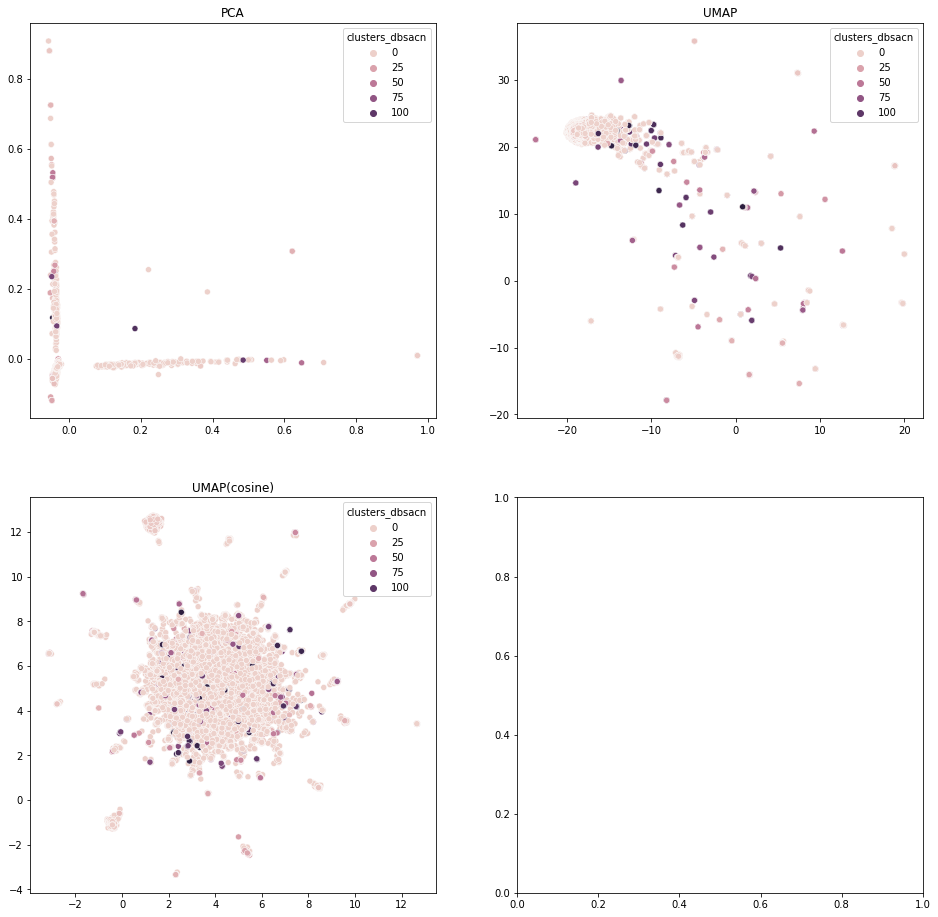

In [35]:
fig, ((ax11, ax12), (ax21, ax22)) = plt.subplots(2, 2, figsize=(16, 16))

ax11.set_title('PCA')
sns.scatterplot(x=text_pca[..., 0], y=text_pca[..., 1], ax=ax11, hue=elon_df['clusters_dbsacn']);

ax12.set_title('UMAP')
sns.scatterplot(x=text_umap[..., 0], y=text_umap[..., 1], ax=ax12, hue=elon_df['clusters_dbsacn']);

ax21.set_title('UMAP(cosine)')
sns.scatterplot(x=text_umap_cosine[..., 0], y=text_umap_cosine[..., 1], ax=ax21, hue=elon_df['clusters_dbsacn']);

In [36]:
elon_df.groupby('clusters_dbsacn')['clusters_dbsacn'].count()

clusters_dbsacn
-1      6552
 0        31
 1       225
 2        51
 3        26
        ... 
 120       5
 121       5
 122       5
 123       6
 124       7
Name: clusters_dbsacn, Length: 126, dtype: int64

In [37]:
cluster = 3

print(print_top_n_words(elon_df.query(f'clusters_dbsacn == {cluster}').text))
elon_df.query(f'clusters_dbsacn == {cluster}').head(10)

[('coming', 26), ('soon', 26), ('yes', 2), ('new', 1), ('version', 1), ('superchargers', 1)]


,text,date,datetime,cluster,clusters_dbsacn
id,,,,,
1210259962598838272,@TeslaOwnersofMA @Tesla @disneyplus @BenSullin...,2019-12-26,2019-12-26 18:03:55,0,3
1186529463762243585,@tecnocato @Tesla Coming soon,2019-10-22,2019-10-22 06:27:23,0,3
1183509770382135297,@TeslaGong Coming v soon,2019-10-13,2019-10-13 22:28:12,0,3
1173323478264623112,"@TeslaTested Yes, coming soon",2019-09-15,2019-09-15 19:51:31,0,3
1152241180635090944,@NickStalburg Coming soon,2019-07-19,2019-07-19 15:37:59,0,3
1144513716425285633,@nichegamer @tomekdrabas @merkinvineyards Merk...,2019-06-28,2019-06-28 07:51:48,0,3
1131238800980451328,@teslainventory Coming soon,2019-05-22,2019-05-22 16:42:02,0,3
1119883893392334848,@v_g_fischer @4thFromOurStar Coming soon,2019-04-21,2019-04-21 08:41:41,0,3
1112035721672482816,@MoWo91 Coming soon!,2019-03-30,2019-03-30 16:55:51,0,3


In [38]:
K = list(range(2, 251))

silhouette = {}

for k in tqdm(K):
    aggl = AgglomerativeClustering(n_clusters=k).fit(text_tfidf)
    silhouette[k] = silhouette_score(text_tfidf, aggl.labels_) if k > 1 else None

100%|████████████████████████████████████████████████████████████████| 249/249 [3:37:12<00:00, 52.34s/it]


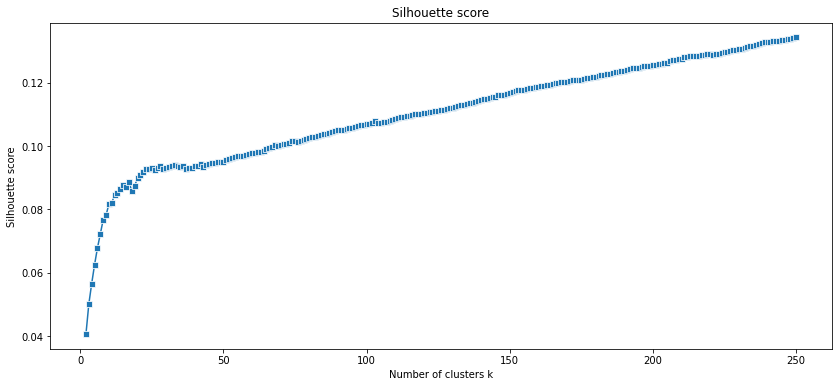

In [39]:
plt.figure(figsize=(14, 6))
sns.lineplot(x=K, y=[silhouette[k] for k in K], marker='s')

plt.title('Silhouette score')
plt.xlabel('Number of clusters k')
plt.ylabel('Silhouette score')

plt.show()

In [40]:
best_k = [*silhouette.keys()][np.argmax([*silhouette.values()])]
best_k

250

In [41]:
%%time
agglomerative = AgglomerativeClustering(n_clusters=best_k)
elon_df['cluster_agglom'] = agglomerative.fit_predict(text_tfidf)

CPU times: user 49.2 s, sys: 119 ms, total: 49.3 s
Wall time: 49.2 s


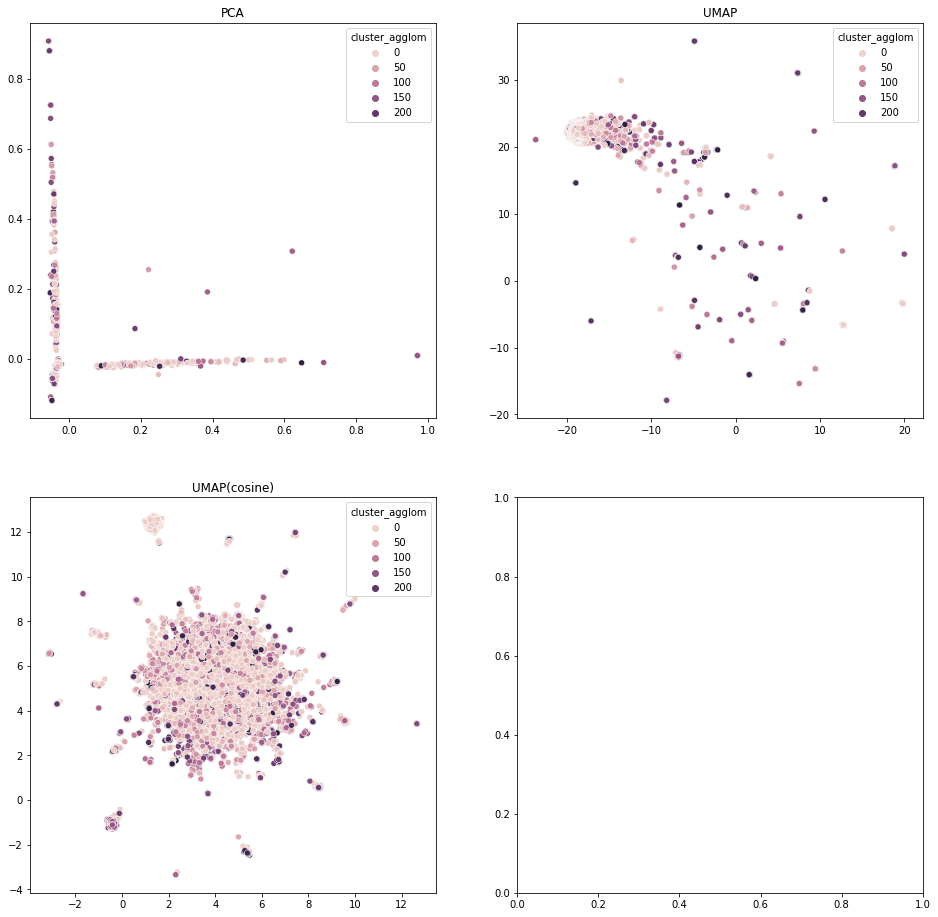

In [42]:
fig, ((ax11, ax12), (ax21, ax22)) = plt.subplots(2, 2, figsize=(16, 16))

ax11.set_title('PCA')
sns.scatterplot(x=text_pca[..., 0], y=text_pca[..., 1], ax=ax11, hue=elon_df['cluster_agglom']);

ax12.set_title('UMAP')
sns.scatterplot(x=text_umap[..., 0], y=text_umap[..., 1], ax=ax12, hue=elon_df['cluster_agglom']);

ax21.set_title('UMAP(cosine)')
sns.scatterplot(x=text_umap_cosine[..., 0], y=text_umap_cosine[..., 1], ax=ax21, hue=elon_df['cluster_agglom']);

In [43]:
elon_df.groupby('cluster_agglom')['cluster_agglom'].count()

cluster_agglom
0       24
1       37
2       32
3       35
4      105
      ... 
245     10
246     12
247     22
248      5
249      6
Name: cluster_agglom, Length: 250, dtype: int64

In [44]:
for cluster in set(elon_df['cluster_agglom']):
    print(
        f'Cluster {cluster:3}. {len(elon_df.query(f"cluster_agglom == {cluster}")):5} tweets total. Top-3 words:', 
        print_top_n_words(elon_df.query(f'cluster_agglom == {cluster}').text, n=3)
    )

Cluster   0.    24 tweets total. Top-3 words: [('fine', 8), ('shirt', 6), ('fix', 5)]
Cluster   1.    37 tweets total. Top-3 words: [('go', 16), ('live', 11), ('goes', 10)]
Cluster   2.    32 tweets total. Top-3 words: [('life', 29), ('multiplanetary', 17), ('light', 9)]
Cluster   3.    35 tweets total. Top-3 words: [('play', 14), ('mode', 13), ('11', 9)]
Cluster   4.   105 tweets total. Top-3 words: [('landing', 36), ('heat', 26), ('starship', 24)]
Cluster   5.    38 tweets total. Top-3 words: [('bar', 26), ('test', 23), ('pressure', 19)]
Cluster   6.  3490 tweets total. Top-3 words: [('tesla', 245), ('would', 151), ('high', 127)]
Cluster   7.    30 tweets total. Top-3 words: [('better', 23), ('slightly', 8), ('much', 7)]
Cluster   8.    20 tweets total. Top-3 words: [('tank', 17), ('liquid', 11), ('oxygen', 9)]
Cluster   9.    54 tweets total. Top-3 words: [('production', 50), ('hard', 19), ('easy', 14)]
Cluster  10.    27 tweets total. Top-3 words: [('really', 14), ('universe', 11),

In [45]:
cluster = 7

print('Entries:', len(elon_df.query(f'cluster_agglom == {cluster}')))
print(print_top_n_words(elon_df.query(f'cluster_agglom == {cluster}').text))
elon_df.query(f'cluster_agglom == {cluster}').head(10)

Entries: 30
[('better', 23), ('slightly', 8), ('much', 7), ('way', 5), ('got', 5), ('tesla', 4), ('yeah', 3), ('yes', 2), ('worse', 2), ('faster', 2), ('heat', 2), ('sure', 2), ('could', 2), ('factory', 2), ('safety', 2), ('industry', 2), ('looks', 2), ('point', 1), ('engine', 1), ('coming', 1), ('lane', 1), ('v10', 1), ('seats', 1), ('almost', 1), ('always', 1)]


,text,date,datetime,cluster,clusters_dbsacn,cluster_agglom
id,,,,,,
1183081171644628992,@wk057 @Tesla Should be much better at this point,2019-10-12,2019-10-12 18:05:06,0,-1,7
1174810563903229952,@chrisleehawaii @Tesla Much better chess engin...,2019-09-19,2019-09-19 22:20:40,0,-1,7
1174351594873188352,@areus Lane offset should be much better in V10.0,2019-09-18,2019-09-18 15:56:53,0,-1,7
1139953128856379392,"@BTermanini @sascha_p @TonyWuGZ @Tesla Yes, ex...",2019-06-15,2019-06-15 17:49:39,0,-1,7
1134025184942313473,@13ericralph31 @PPathole @Erdayastronaut @rmar...,2019-05-30,2019-05-30 09:14:07,0,-1,7
1131429686548942848,@13ericralph31 @SPEXcast @bluemoondance74 @Ori...,2019-05-23,2019-05-23 05:20:32,0,-1,7
1126609124446195712,@TeslaNY @Tesla @MotorTrend Latest Model S is ...,2019-05-09,2019-05-09 22:05:21,0,-1,7
1115693611494981638,"@bonnienorman @vincent13031925 @Tesla No, it’s...",2019-04-09,2019-04-09 19:11:00,0,-1,7
1098775062985945088,@nextspaceflight It’s designed to be way bette...,2019-02-22,2019-02-22 02:42:43,0,-1,7
